# Model Selection 
### Objectives 
    1) Create rigrourous 10-Fold cross validation framework for models
    2) Fit models starting at day 0
    3) Generate diagnostics for models and justify selection

In [15]:
# imports and loading the cleaned and anotated data
# data transforms are defined and detailed in the Data Exploration notebook 
import pandas as pd 
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import math
import time
from sklearn import linear_model
%matplotlib inline  
plt.style.use('ggplot')
# load data from anotated csv if it is in your local directory 
adf=pd.read_csv('Anotated_Strategy_Data_Set.csv',parse_dates=['trial_date','subscription_date','trial_dateTime','sub_dateTime'], infer_datetime_format=True)
# I dont think you can parse time deltas 
adf['subLag']=adf['sub_dateTime']-adf['trial_dateTime']
### big issue here 
#df=df.sample(10000)


In [18]:
# function to anotate cohort variables give a diff
# assumes there is master df called df 
def anotate_cohort_vars (diff,df):
    cScore={}
    for row in df.trial_date.unique():
        sdf=df[df.trial_date==row]
        # calculate day0 yield 
        if diff >= np.timedelta64(1, 'D'):
            i1=sdf[(sdf.subLag != np.timedelta64(0, 's')) & (sdf.subLag < np.timedelta64(1, 'D')) ].id.count()
        else: 
            i1=0
        # calculate yield to date 
        i2=sdf[(sdf.subLag != np.timedelta64(0, 's')) & (sdf.subLag < diff) ].id.count()
        # etc etc 
        c=sdf.id.count()
        cScore[row]=(row,c,i1/c,i2/c)
    #print (cScore[np.datetime64('2013-05-01T00:00:00.000000000')])
    toAdd=pd.DataFrame.from_dict(cScore,orient='index')
    toAdd.columns = ['trial_date','cohort_numTrials', 'cohort_day0_yield','cohort_ytd']
    df=df.join(toAdd, on='trial_date',rsuffix='throwaway')
    df.drop(['trial_datethrowaway','Unnamed: 0'],inplace=True,axis=1)
    return df
print(adf.shape)
delta=np.timedelta64(0,'D')
# filter out data that occurs after this date 
df=adf[(adf.sub_hour_start.isnull()) | (adf.subLag >= delta)]
print(df.shape)
df=anotate_cohort_vars(delta,df)
variables = ['trial_hour','us','uk','can','aus','mon','tueWed','sunSat','thr','cohort_numTrials','cohort_day0_yield','cohort_ytd']
ac=[]

(74891, 21)
(74891, 21)


In [19]:
# Prototype script for CV 
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
plots=[]
start=time.time()
for partition in partitions: 
    print('--- Start Fold ---')
    print('Partioning Data...')
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    # call sklearn.model()
    #generate the diagnostics and store them in the respective lists 

# draw final charts and present model findings.

fin=time.time()
print('--- End of CV ---')
print('Runtime')
print(fin-start)

--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- Start Fold ---
Partioning Data...
--- End of CV ---
Runtime
0.6434569358825684


In [4]:
test.columns

Index(['id', 'trial_date', 'trial_hour', 'day_of_week', 'trial_country',
       'subscription_date', 'sub_hour_start', 'sub_label', 'trial_dateTime',
       'sub_dateTime', 'subLag', 'country_count', 'us', 'uk', 'can', 'aus',
       'mon', 'tueWed', 'sunSat', 'thr', 'cohort_numTrials',
       'cohort_day0_yield', 'cohort_ytd'],
      dtype='object')

### Linear Regression to Estimate P(Subscribe)

0.927065365256
0.91541536668
0.997890712988
0.983218645346
0.900020021642
0.906640739735
0.988456512078
0.985600811836
0.920161433583
0.984576875542
0.990391665097
0.958535254708
0.903324625759
0.965340321133
0.942221738915
0.909029303141
0.985201464833
0.933677552691
0.918414997634
0.978833708638
0.933409366252
0.918721683218
0.956277081197
0.962559038433
0.995864201798
0.985520979858
0.986989425807
0.977008140443
0.991487643925
0.977615229903
0.984565488477


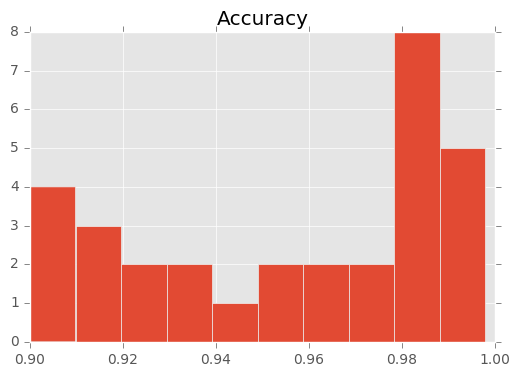

Accuracy    0.956904
dtype: float64


In [24]:
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,31)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
plots=[]
start=time.time()
for partition in partitions: 
    #print('--- Start Fold ---')
    #print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- LINEAR
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    print(r)
    rocauc.append(r)

# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
#print('Runtime')
#print(fin-start)
a=pd.DataFrame(rocauc, columns=['Accuracy'])
a.hist()
pyplt.show()
print(a.mean())
ac.append(a.mean())

In [29]:

math.sqrt(np.var(rocauc))*1.96/math.sqrt(len(rocauc))

0.011421966635560525

### Logistic Regression to Estimate P(Subscribe)

--- Start Fold ---
Partioning Data...
Fitting Model...
[-5.69616731  0.91942312]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-6.05186031  0.95456642]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-8.63308242  0.80034534]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-5.66258923  0.78269367]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-6.87723999  0.90338679]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-6.6130584   0.86929109]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-6.57303958  0.87703958]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-5.72725761  0.86393581]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-5.27031814  0.90242141]
--- Start Fold ---
Partioning Data...
Fitting Model...
[-7.55145317  0.98563331]
Runtime
9.92203402519226


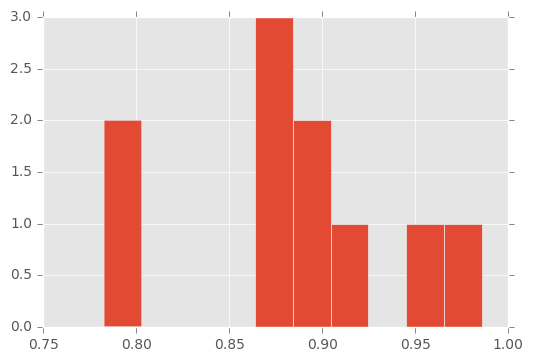

0.8858736551242836


In [6]:
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
datadump=[]
start=time.time()
for partition in partitions: 
    print('--- Start Fold ---')
    print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- GBC
    # Create linear regression object
    regr = linear_model.LogisticRegression(n_jobs =4)
    # Train the model using the training sets
    print('Fitting Model...')
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict_proba(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    print(r)
    rocauc.append(r)
    datadump.append(regr.predict_proba(test_x))
# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
print('Runtime')
print(fin-start)
a=pd.DataFrame(rocauc, columns=['a','b'])
a.b.hist()
pyplt.show()
print(a.b.mean())
ac.append(a.b.mean())

### Linear SVC

In [7]:
foo="""
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
datadump=[]
start=time.time()
for partition in partitions: 
    print('--- Start Fold ---')
    print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- GBC
    # Create linear regression object
    regr = svm.SVC(kernel='linear',probability =True,cache_size=7000)
    # Train the model using the training sets
    print('Fitting Model...')
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict_proba(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    print(r)
    rocauc.append(r)
    datadump.append(regr.predict_proba(test_x))
# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
print('Runtime')
print(fin-start)
a=pd.DataFrame(rocauc, columns=['a','b'])
a.b.hist()
pyplt.show()
print(a.b.mean())
""" 

### RGB SVC

In [8]:
foo2="""partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
datadump=[]
start=time.time()
for partition in partitions: 
    print('--- Start Fold ---')
    print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- GBC
    # Create linear regression object
    regr = svm.SVC(probability =True,cache_size=7000)
    # Train the model using the training sets
    print('Fitting Model...')
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict_proba(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    print(r)
    rocauc.append(r)
    datadump.append(regr.predict_proba(test_x))
# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
print('Runtime')
print(fin-start)
a=pd.DataFrame(rocauc, columns=['a','b'])
a.b.hist()
pyplt.show()
print(a.b.mean())
"""

### KNeighbors

Runtime
13.153958082199097


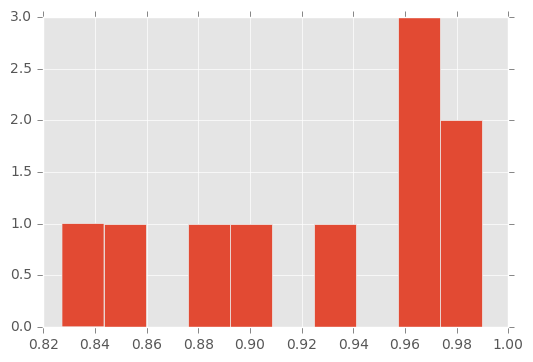

Mean accuracy
0.9256551258436172


In [9]:
from sklearn import neighbors 
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
datadump=[]
start=time.time()
for partition in partitions: 
    #print('--- Start Fold ---')
    #print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- GBC
    # Create linear regression object
    regr = neighbors.KNeighborsClassifier(n_neighbors=30, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=2)
    # Train the model using the training sets
    #print('Fitting Model...')
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict_proba(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    #print(r)
    rocauc.append(r)
    datadump.append(regr.predict_proba(test_x))
# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
print('Runtime')
print(fin-start)
a=pd.DataFrame(rocauc, columns=['a','b'])
a.b.hist()
pyplt.show()
print('Mean accuracy')
print(a.b.mean())
ac.append(a.b.mean())

### Gradient Boosting 

--- Start Fold 1 ---
Runtime: 5.835137128829956
--- Start Fold 2 ---
Runtime: 10.528465032577515
--- Start Fold 3 ---
Runtime: 7.976655006408691
--- Start Fold 4 ---
Runtime: 10.462416172027588
--- Start Fold 5 ---
Runtime: 7.647420167922974
--- Start Fold 6 ---
Runtime: 5.062590837478638
--- Start Fold 7 ---
Runtime: 5.593964099884033
--- Start Fold 8 ---
Runtime: 5.20969295501709
--- Start Fold 9 ---
Runtime: 8.662142992019653
--- Start Fold 10 ---
Runtime: 9.241550922393799


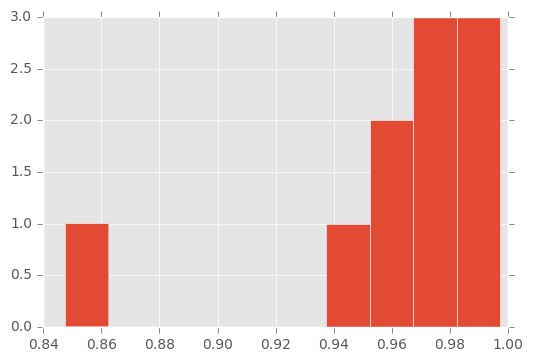

Mean accuracy
0.9622088530009864
Runtime
76.22804307937622


In [22]:
#GBC
from sklearn import ensemble 
partitions = df.trial_date.unique()
np.random.shuffle(partitions)
partitions=np.array_split(partitions,10)
#partions is now the days to hold out for training we can than create the df's we need from df to generate our test and train data 
#define list of ROC scores to average  
rocauc=[]
#define list to hold line objects / fits so we can generate nice plots 
datadump=[]
start=time.time()
count=0
for partition in partitions: 
    t1=time.time()
    count+=1
    print('--- Start Fold '+ str(count) +' ---')
    #print('Partioning Data...')
    # now we can fit a model for this random data on train and then validate on test once we select to cols we want 
    #subset train & test for apropraite cols
    test =df[df.trial_date.isin(partition)]
    train=df[df.trial_date.isin(partition)==False]
    train_x=train[variables].as_matrix()
    train_y=train['sub_label'].as_matrix()
    test_x=test[variables].as_matrix()
    test_y=test['sub_label'].as_matrix()
    # call sklearn.model() -- GBC
    # Create linear regression object
    regr =ensemble.GradientBoostingClassifier( learning_rate=.1, n_estimators=100, max_depth=3)
    # Train the model using the training sets
    #print('Fitting Model...')
    regr.fit(train_x, train_y)
    #generate the diagnostics and store them in the respective lists 
    p=sum(regr.predict_proba(test_x))
    a=test[test.sub_label ==1].id.count()
    r=1-abs(p-a)/a 
    #print(r)
    rocauc.append(r)
    #datadump.append(regr.predict_proba(test_x))
    t2=time.time()
    print('Runtime: '+str(t2-t1))
# draw final charts and present model findings.
fin=time.time()
#print('--- End of CV ---')
a=pd.DataFrame(rocauc, columns=['a','b'])
a.b.hist()
pyplt.show()
print('Mean accuracy')
print(a.b.mean())
print('Runtime')
print(fin-start)
ac.append(a.b.mean())

### Parameter Tuning Results # for day 0
    loss='deviance', learning_rate=0.1, n_estimators=100, max_depth=3
    Mean accuracy
    0.9697209768350554
    Runtime
    67.9241590499878
    loss='deviance', learning_rate=0.05, n_estimators=200, max_depth=3
    Mean accuracy
    0.9544958961718223
    Runtime
    76.51476979255676
    loss='deviance', learning_rate=0.2, n_estimators=50, max_depth=3
    Mean accuracy
    Mean accuracy
    0.9660317101856375
    Runtime
    35.933475971221924


#### Parameter Tuning Results # for day 0 
-------------------------------------------------------------------
    loss='deviance', learning_rate=0.1, n_estimators=100, max_depth=3
    Mean accuracy
    0.9697209768350554
    Runtime
    67.9241590499878
    
-------------------------------------------------------------------
    loss='deviance', learning_rate=0.05, n_estimators=200, max_depth=3
    Mean accuracy
    0.9544958961718223
    Runtime
    76.51476979255676
-------------------------------------------------------------------
    loss='deviance', learning_rate=0.2, n_estimators=50, max_depth=3
    Mean accuracy
    Mean accuracy
    0.9660317101856375
    Runtime
    35.933475971221924
-------------------------------------------------------------------


In [11]:
ac

[Accuracy    0.937552
 dtype: float64, 0.8858736551242836, 0.9256551258436172, 0.9355666258663001]

In [13]:
ac[0]-ac[3]

Accuracy    0.001985
dtype: float64

In [ ]:
x`

In [14]:
df

,id,trial_date,trial_hour,day_of_week,trial_country,subscription_date,sub_hour_start,sub_label,trial_dateTime,sub_dateTime,...,uk,can,aus,mon,tueWed,sunSat,thr,cohort_numTrials,cohort_day0_yield,cohort_ytd
0,51809381e4b03c6b86a6256f,2013-05-01,0,Wednesday,United States,2013-05-14,23.0,1,2013-05-01 00:00:00,2013-05-14 23:00:00,...,0,0,0,0,1,0,0,2407,0.0,0.0
1,518093ade4b00cbd5d9abe26,2013-05-01,0,Wednesday,United States,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
2,518093d6e4b0c1fda9c05d54,2013-05-01,0,Wednesday,United States,2013-05-15,20.0,1,2013-05-01 00:00:00,2013-05-15 20:00:00,...,0,0,0,0,1,0,0,2407,0.0,0.0
3,518093f2e4b0b0f0caf55867,2013-05-01,0,Wednesday,United States,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
4,518093fee4b01eeb7aec8bfc,2013-05-01,0,Wednesday,United States,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
6,51809433e4b00f39571980e8,2013-05-01,0,Wednesday,United States,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
7,51809449e4b01d30b4a23394,2013-05-01,0,Wednesday,Canada,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,1,0,0,1,0,0,2407,0.0,0.0
9,5180946be4b0b0f0caf55a1f,2013-05-01,0,Wednesday,Indonesia,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
10,51809472e4b0337a302c1845,2013-05-01,0,Wednesday,United States,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,0,0,1,0,0,2407,0.0,0.0
12,518094b4e4b0bec12a2b72d8,2013-05-01,0,Wednesday,Australia,NaT,NaN,0,2013-05-01 00:00:00,NaT,...,0,0,1,0,1,0,0,2407,0.0,0.0
